
## 02 - RNN Baseline Training
# Notebook scope:
- reuse the prepared embeddings and tokenised data
- train a simple RNN classifier with pooled sentence representations
- explore regularisation strategies and sentence representation variants
- report validation curves, best config, and topic-wise accuracy

## Imports & data setup

In [1]:
from dataclasses import replace
from pathlib import Path
import random
from textwrap import shorten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

from src.config import load_data_config
from src.dataset_pipeline import prepare_tokenised_splits
from src.embeddings import load_torchtext_glove
from src.reports import build_vocabulary_report
from src.training import RNNExperimentConfig, train_rnn_model
from src.evaluation import (
    evaluate_model,
    topic_accuracy_table,
    classification_report_table,
)
from src.plotting import latex_set_size, plot_training_curves, plot_support_and_f1_by_topic
import torch


In [2]:

SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
sns.set_theme(style="whitegrid")

data_config = load_data_config(Path("configs/data.yaml"))
splits = prepare_tokenised_splits(data_config)
len(splits.train), len(splits.validation), len(splits.test)

(4361, 1091, 500)

## Embedding prep

In [3]:
vocab_report = build_vocabulary_report(
    tokenised_dataset=splits.train,
    min_freq=data_config.vocabulary_min_freq,
    specials=data_config.vocabulary_specials,
)

embedding_result = load_torchtext_glove(
    vocabulary=vocab_report.vocabulary,
    name="6B",
    dim=100,
    trainable=True,
    random_seed=7,
)

## Baseline configuration

In [4]:
baseline_config = RNNExperimentConfig(
    epochs=40,
    batch_size=64,
    hidden_dim=128,
    num_layers=1,
    dropout=0.3,
    learning_rate=1e-3,
    weight_decay=0.0,
    grad_clip=1.0,
    pooling="last_hidden",
    optimizer="adam",
    early_stopping_patience=3,
)

## Train baseline RNN

In [5]:
history, model, label_to_index, dataloaders = train_rnn_model(
    config=baseline_config,
    splits=splits,
    vocabulary=vocab_report.vocabulary,
    embedding_result=embedding_result,
)
index_to_label = {idx: label for label, idx in label_to_index.items()}
history.best_epoch, len(history.train_loss)

(8, 11)

## Training curves

(<Figure size 1259.84x389.313 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

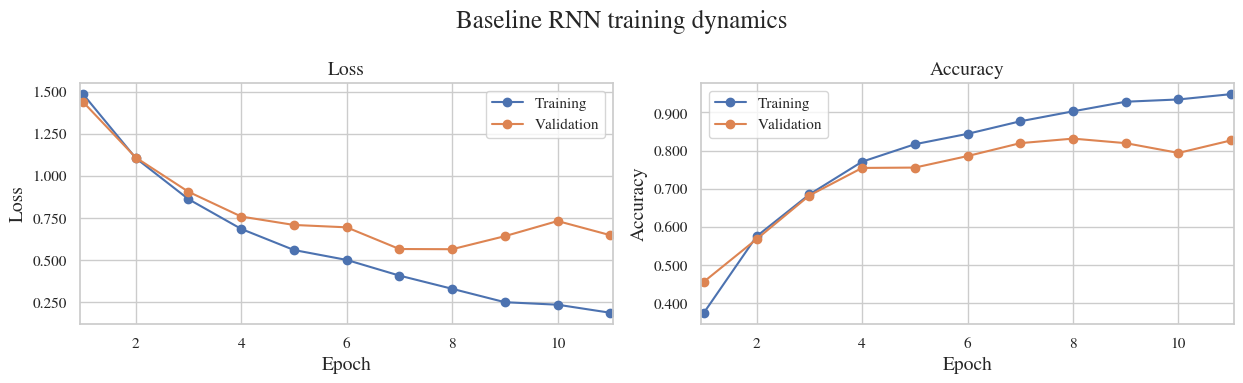

In [6]:
plot_training_curves(
    history,
    title="Baseline RNN training dynamics",
    output_path=Path("plots/part2_rnn_baseline_curves.png"),
    figure_fraction=1,
)

## Validation & test metrics

In [7]:
val_eval = evaluate_model(model, dataloaders.validation)
test_eval = evaluate_model(model, dataloaders.test)

baseline_metrics = pd.DataFrame(
    [
        {"split": "validation", "loss": val_eval.loss, "accuracy": val_eval.accuracy},
        {"split": "test", "loss": test_eval.loss, "accuracy": test_eval.accuracy},
    ]
)
baseline_metrics

,split,loss,accuracy
0,validation,0.646651,0.826764
1,test,0.459545,0.866000


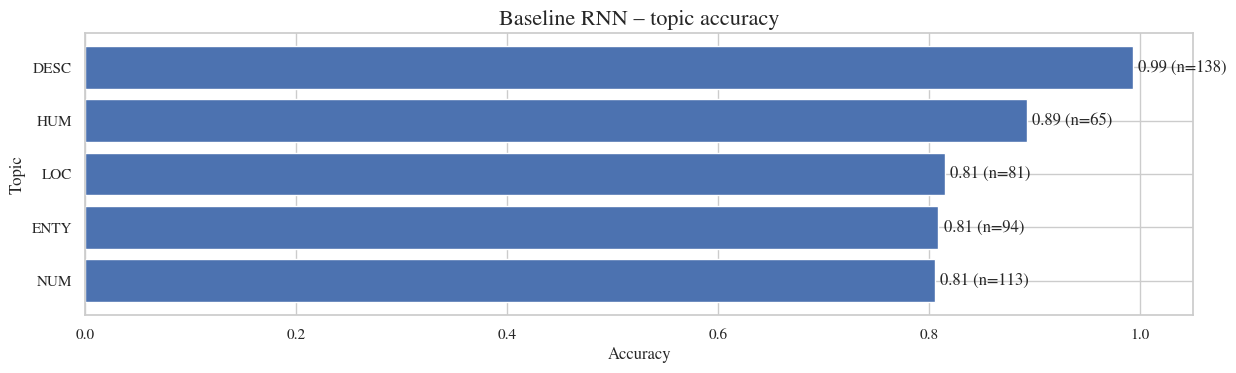

In [8]:
topic_accuracy_df = topic_accuracy_table(test_eval, index_to_label)
filtered_topics = topic_accuracy_df[topic_accuracy_df['support'] > 10 ].copy()
sorted_topics = filtered_topics.sort_values('accuracy')

width, height = latex_set_size(fraction=1)
fig, ax = plt.subplots(figsize=(width * 2, height))
bars = ax.barh(sorted_topics['label'], sorted_topics['accuracy'])
ax.set_xlabel('Accuracy')
ax.set_ylabel('Topic')
ax.set_title('Baseline RNN – topic accuracy',fontsize=16)
ax.set_xlim(0, 1.05)
ax.bar_label(bars, labels=[f"{acc:.2f} (n={supp})" for acc, supp in zip(sorted_topics['accuracy'], sorted_topics['support'])], padding=4)


plt.tight_layout()
fig.savefig('plots/part2_topic_accuracy.png', dpi=300)
plt.show()


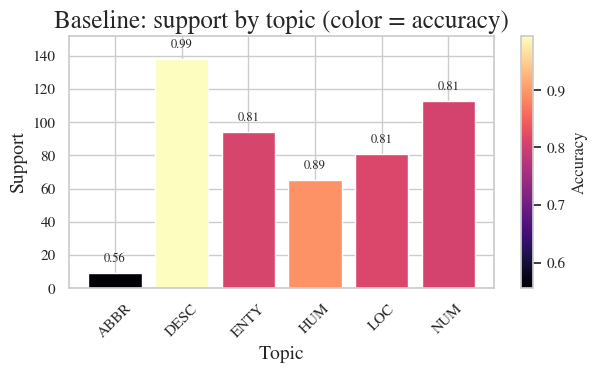

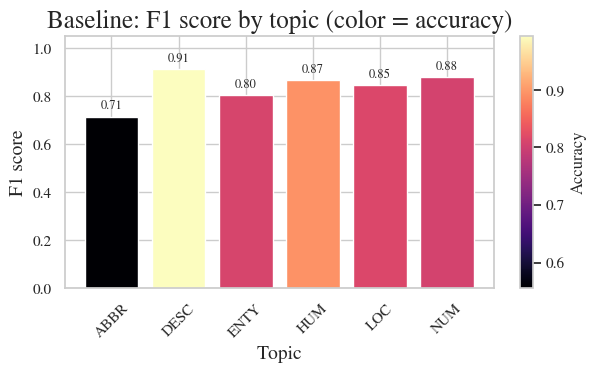

((<Figure size 629.921x389.313 with 2 Axes>,
  <Axes: title={'center': 'Baseline: support by topic (color = accuracy)'}, xlabel='Topic', ylabel='Support'>),
 (<Figure size 629.921x389.313 with 2 Axes>,
  <Axes: title={'center': 'Baseline: F1 score by topic (color = accuracy)'}, xlabel='Topic', ylabel='F1 score'>))

In [9]:
baseline_report_df = classification_report_table(test_eval, index_to_label)
baseline_label_rows = baseline_report_df.loc[
    ~baseline_report_df.index.isin(['accuracy', 'macro avg', 'weighted avg', 'micro avg'])
].copy()
if 'accuracy' not in baseline_label_rows.columns:
    baseline_label_rows['accuracy'] = baseline_label_rows.get('recall', 0.0)

width, height = latex_set_size(fraction=1)
plot_support_and_f1_by_topic(
    baseline_label_rows,
    figsize=(width , height),
    support_title='Baseline: support by topic (color = accuracy)',
    f1_title='Baseline: F1 score by topic (color = accuracy)',
    support_output_path=Path('plots/part2_classification_support.png'),
    f1_output_path=Path('plots/part2_classification_f1.png'),
)


## OOV initialization strategy comparison


In [10]:
strategies = ["sif", "mean", "zero"]
strategy_histories = {}
strategy_models = {}

for strategy in strategies:
    print(f"Training with {strategy} strategy...")
    embedding_result = load_torchtext_glove(
        vocabulary=vocab_report.vocabulary,
        name="6B",
        dim=100,
        trainable=True,
        random_seed=SEED,
        oov_strategy=strategy,
    )
    
    history, model, _, _ = train_rnn_model(
        config=baseline_config,
        splits=splits,
        vocabulary=vocab_report.vocabulary,
        embedding_result=embedding_result,
    )
    
    strategy_histories[strategy] = history
    strategy_models[strategy] = model


Training with sif strategy...
Training with mean strategy...
Training with zero strategy...


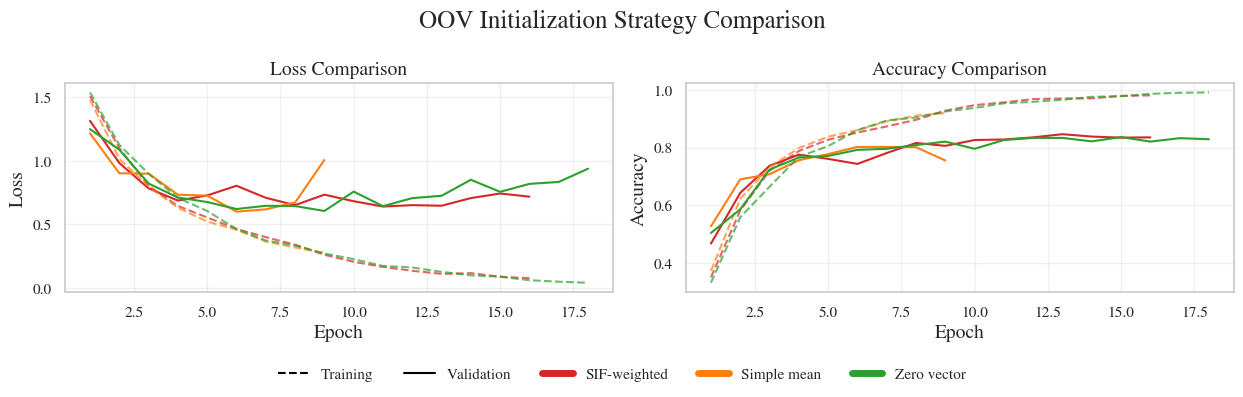

Best validation accuracies:
  sif   : 0.8460
  mean  : 0.8020
  zero  : 0.8359


In [11]:
width, height = latex_set_size(fraction=1)
fig, axes = plt.subplots(1, 2, figsize=(width * 2, height))

colors = {
    'sif': sns.color_palette('tab10')[3],
    'mean': sns.color_palette('tab10')[1],
    'zero': sns.color_palette('tab10')[2],
}
strategy_labels = {
    'sif': 'SIF-weighted',
    'mean': 'Simple mean',
    'zero': 'Zero vector',
}

for strategy in strategies:
    history_obj = strategy_histories[strategy]
    epochs = range(1, len(history_obj.train_loss) + 1)
    color = colors[strategy]
    axes[0].plot(epochs, history_obj.train_loss, linestyle='--', color=color, alpha=0.7)
    axes[0].plot(epochs, history_obj.val_loss, linestyle='-', color=color)
    axes[1].plot(epochs, history_obj.train_accuracy, linestyle='--', color=color, alpha=0.7)
    axes[1].plot(epochs, history_obj.val_accuracy, linestyle='-', color=color)

axes[0].set_xlabel('Epoch', fontsize=14)
axes[0].set_ylabel('Loss', fontsize=14)
axes[0].set_title('Loss Comparison', fontsize=14)
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].set_ylabel('Accuracy', fontsize=14)
axes[1].set_title('Accuracy Comparison', fontsize=14)
axes[1].grid(True, alpha=0.3)

dataset_handles = [
    plt.Line2D([], [], color='black', linestyle='--', label='Training'),
    plt.Line2D([], [], color='black', linestyle='-', label='Validation'),
]
strategy_handles = [
    plt.Line2D([], [], color=colors['sif'],lw=5, label=strategy_labels['sif']),
    plt.Line2D([], [], color=colors['mean'],lw=5, label=strategy_labels['mean']),
    plt.Line2D([], [], color=colors['zero'],lw=5, label=strategy_labels['zero']),
]

handles = dataset_handles + strategy_handles
labels = [handle.get_label() for handle in handles]
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.01), ncol=5, frameon=False)

fig.suptitle('OOV Initialization Strategy Comparison', fontsize=18)
fig.tight_layout(rect=(0, 0.08, 1, 1))
fig.savefig('plots/oov_strategy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('Best validation accuracies:')
for strategy in strategies:
    history_obj = strategy_histories[strategy]
    best_val_acc = max(history_obj.val_accuracy) if history_obj.val_accuracy else 0.0
    print(f"  {strategy:6s}: {best_val_acc:.4f}")


## Regularisation comparison

In [12]:
dropout_grid = np.linspace(0.0, 0.6, 7)
weight_decay_grid = np.concatenate(([0.0], np.logspace(-6, -2, 6)))

regularisation_variants = []
for dropout in dropout_grid:
    for weight_decay in weight_decay_grid:
        cfg = replace(
            baseline_config,
            dropout=float(dropout),
            weight_decay=float(weight_decay),
        )
        name = f"dropout_{dropout:.2f}_wd_{weight_decay:.0e}"
        regularisation_variants.append((name, cfg))

reg_results = []
for name, cfg in regularisation_variants:
    hist, mdl, _, loaders = train_rnn_model(
        config=cfg,
        splits=splits,
        vocabulary=vocab_report.vocabulary,
        embedding_result=embedding_result,
    )
    val_res = evaluate_model(mdl, loaders.validation)
    test_res = evaluate_model(mdl, loaders.test)
    reg_results.append(
        {
            "name": name,
            "dropout": float(f"{cfg.dropout:.3f}"),
            "weight_decay": float(f"{cfg.weight_decay:.3f}"),
            "grad_clip": float(f"{cfg.grad_clip:.3f}"),
            "best_epoch": int(hist.best_epoch),
            "val_accuracy": float(f"{val_res.accuracy:.3f}"),
            "test_accuracy": float(f"{test_res.accuracy:.3f}"),
        }
    )

regularisation_df = pd.DataFrame(reg_results).sort_values(
    "test_accuracy", ascending=False
)

heatmap_data = (
    regularisation_df
    .pivot_table(index="weight_decay", columns="dropout", values="val_accuracy")
    .sort_index()
    .sort_index(axis=1)
)


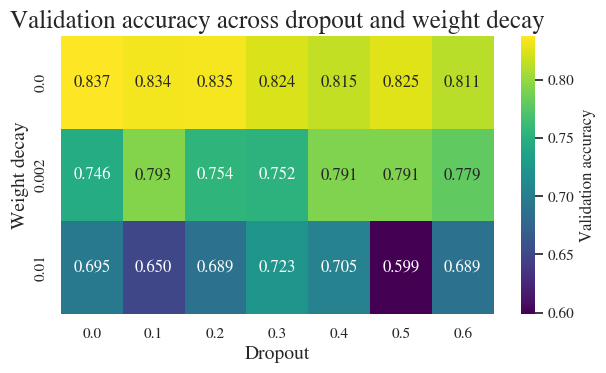

,name,dropout,weight_decay,grad_clip,best_epoch,val_accuracy,test_accuracy
10,dropout_0.10_wd_4e-05,0.1,0.000,1.0,13,0.841,0.900
38,dropout_0.50_wd_4e-05,0.5,0.000,1.0,8,0.812,0.892
29,dropout_0.40_wd_1e-06,0.4,0.000,1.0,12,0.831,0.890
21,dropout_0.30_wd_0e+00,0.3,0.000,1.0,15,0.849,0.884
24,dropout_0.30_wd_4e-05,0.3,0.000,1.0,9,0.807,0.882
3,dropout_0.00_wd_4e-05,0.0,0.000,1.0,9,0.840,0.880
11,dropout_0.10_wd_3e-04,0.1,0.000,1.0,11,0.824,0.880
14,dropout_0.20_wd_0e+00,0.2,0.000,1.0,16,0.844,0.878
8,dropout_0.10_wd_1e-06,0.1,0.000,1.0,11,0.840,0.878
23,dropout_0.30_wd_6e-06,0.3,0.000,1.0,11,0.830,0.876


In [13]:
plt.figure(figsize=latex_set_size(fraction=1))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    cbar_kws={"label": "Validation accuracy"},
)
plt.title("Validation accuracy across dropout and weight decay", size=18)
plt.xlabel("Dropout",fontsize=14)
plt.ylabel("Weight decay",fontsize=14)
plt.tight_layout()
plt.savefig('part2_heatmap.png')
plt.show()

regularisation_df


In [14]:
best_regulariser = regularisation_df.iloc[0]
control_row = regularisation_df.loc[

    (regularisation_df["dropout"] == 0.0)
    & (regularisation_df["weight_decay"] == 0.0)
].iloc[0]
display(pd.DataFrame([best_regulariser, control_row]))


,name,dropout,weight_decay,grad_clip,best_epoch,val_accuracy,test_accuracy
10,dropout_0.10_wd_4e-05,0.1,0.0,1.0,13,0.841,0.90
3,dropout_0.00_wd_4e-05,0.0,0.0,1.0,9,0.840,0.88


## Sentence representation strategies

In [15]:
pooling_options = ["last_hidden", "mean", "max", "attention"]
pooling_results = []

for pooling in pooling_options:
    cfg = replace(baseline_config, pooling=pooling)
    hist, mdl, _, loaders = train_rnn_model(
        config=cfg,
        splits=splits,
        vocabulary=vocab_report.vocabulary,
        embedding_result=embedding_result,
    )
    test_res = evaluate_model(mdl, loaders.test)
    pooling_results.append(
        {
            "pooling": pooling,
            "best_epoch": hist.best_epoch,
            "test_accuracy": test_res.accuracy,
        }
    )

pooling_df = pd.DataFrame(pooling_results).sort_values(
    "test_accuracy", ascending=False
)
pooling_df

,pooling,best_epoch,test_accuracy
2,max,12,0.882
1,mean,10,0.874
0,last_hidden,19,0.864
3,attention,9,0.862


In [16]:
best_pooling = pooling_df.iloc[0]
display(best_pooling.to_frame().T)


,pooling,best_epoch,test_accuracy
2,max,12,0.882


## Best configuration evaluation


In [17]:
best_config = replace(
    baseline_config,
    dropout=float(best_regulariser['dropout']),
    weight_decay=float(best_regulariser['weight_decay']),
    grad_clip=float(best_regulariser['grad_clip']),
    pooling=str(best_pooling['pooling']),
)
best_history, best_model, best_label_to_index, best_dataloaders = train_rnn_model(
    config=best_config,
    splits=splits,
    vocabulary=vocab_report.vocabulary,
    embedding_result=embedding_result,
)
best_val_eval = evaluate_model(best_model, best_dataloaders.validation)
best_test_eval = evaluate_model(best_model, best_dataloaders.test)
best_index_to_label = {idx: label for label, idx in best_label_to_index.items()}
display(Markdown(f"Best config uses pooling={best_config.pooling}, dropout={best_config.dropout}, weight_decay={best_config.weight_decay}, grad_clip={best_config.grad_clip}."))


Best config uses pooling=max, dropout=0.1, weight_decay=0.0, grad_clip=1.0.

(<Figure size 1070.87x330.916 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

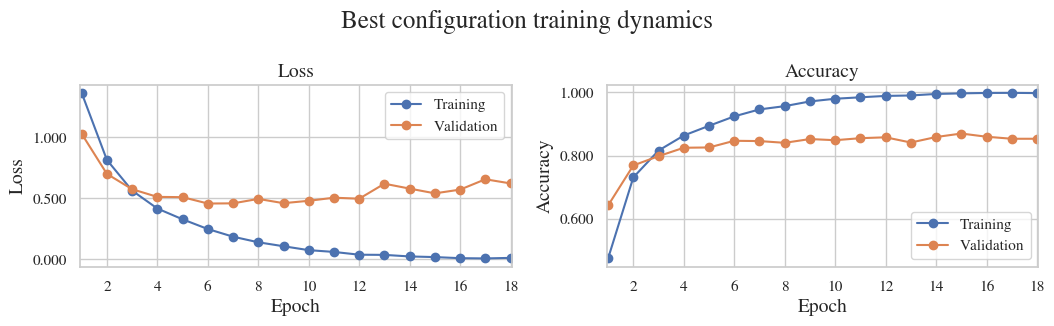

In [18]:
plot_training_curves(
    best_history,
    title="Best configuration training dynamics",
    output_path=Path("plots/part2_best_rnn_curves.png"),
    figure_fraction=0.85,
)


### Topic-wise accuracy (best configuration)


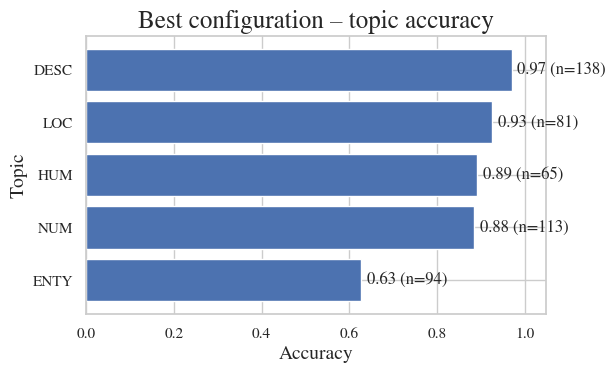

In [19]:
best_topic_accuracy_df = topic_accuracy_table(best_test_eval, best_index_to_label)
filtered_best_topics = best_topic_accuracy_df[best_topic_accuracy_df['support'] > 10].copy()
sorted_best_topics = filtered_best_topics.sort_values('accuracy')
fig, ax = plt.subplots(figsize=latex_set_size(fraction=1))
bars = ax.barh(sorted_best_topics['label'], sorted_best_topics['accuracy'])
ax.set_xlabel('Accuracy',fontsize=14)
ax.set_ylabel('Topic',fontsize=14)
ax.set_title('Best configuration – topic accuracy',fontsize=18)
ax.set_xlim(0, 1.05)
ax.bar_label(bars, labels=[f"{acc:.2f} (n={supp})" for acc, supp in zip(sorted_best_topics['accuracy'], sorted_best_topics['support'])], padding=4)
plt.tight_layout()
fig.savefig('plots/part2_best_topic_accuracy.png', dpi=300)
plt.show()


### Classification report (best configuration)


In [20]:
best_class_report_df = classification_report_table(best_test_eval, best_index_to_label)
best_label_rows = best_class_report_df.loc[
    ~best_class_report_df.index.isin(['accuracy', 'macro avg', 'weighted avg', 'micro avg'])
].copy()
if 'accuracy' not in best_label_rows.columns:
    best_label_rows['accuracy'] = best_label_rows.get('recall', 0.0)


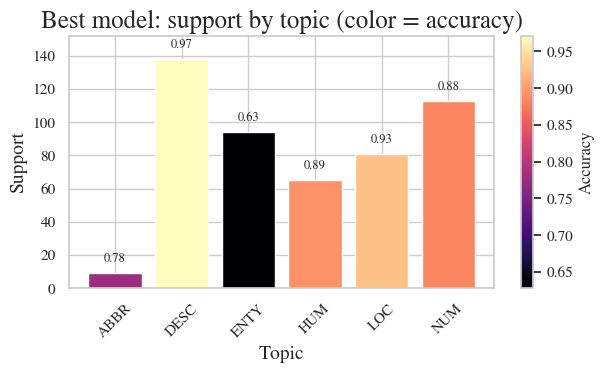

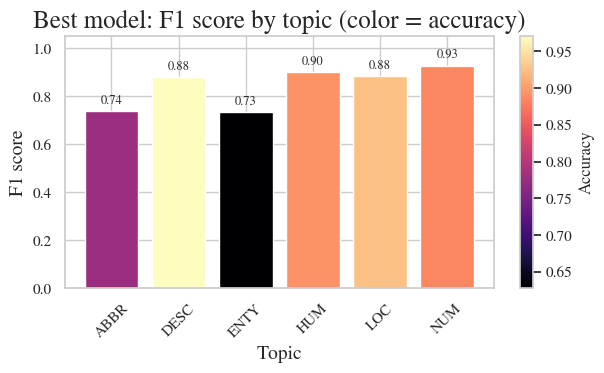

((<Figure size 629.921x389.313 with 2 Axes>,
  <Axes: title={'center': 'Best model: support by topic (color = accuracy)'}, xlabel='Topic', ylabel='Support'>),
 (<Figure size 629.921x389.313 with 2 Axes>,
  <Axes: title={'center': 'Best model: F1 score by topic (color = accuracy)'}, xlabel='Topic', ylabel='F1 score'>))

In [21]:
width, height = latex_set_size(fraction=1)
plot_support_and_f1_by_topic(
    best_label_rows,
    figsize=(width , height),
    support_title='Best model: support by topic (color = accuracy)',
    f1_title='Best model: F1 score by topic (color = accuracy)',
    support_output_path=Path('plots/part2_best_classification_support.png'),
    f1_output_path=Path('plots/part2_best_classification_f1.png'),
)


In [22]:
best_averages_df = best_class_report_df.loc[
    ['accuracy', 'macro avg', 'weighted avg'],
    [col for col in best_class_report_df.columns if col in ['precision', 'recall', 'f1-score']],
]
best_averages_df


,precision,recall,f1-score
accuracy,0.866000,0.866000,0.866000
macro avg,0.850469,0.846607,0.842659
weighted avg,0.873360,0.866000,0.862670


In [23]:
lowest_best_topics = best_topic_accuracy_df.sort_values('accuracy').head(2)
notes = ', '.join(f"{row.label} ({row.accuracy:.2f})" for row in lowest_best_topics.itertuples())
display(Markdown(f"Best model weakest topics: {notes}."))


Best model weakest topics: ENTY (0.63), ABBR (0.78).

## Summary

In [24]:
summary = pd.DataFrame(
    [
        {
            'epochs': best_config.epochs,
            'batch_size': best_config.batch_size,
            'optimizer': best_config.optimizer,
            'learning_rate': best_config.learning_rate,
            'hidden_dim': best_config.hidden_dim,
            'num_layers': best_config.num_layers,
            'dropout': best_config.dropout,
            'weight_decay': best_config.weight_decay,
            'grad_clip': best_config.grad_clip,
            'pooling': best_config.pooling,
            'best_epoch': best_history.best_epoch,
            'val_accuracy': best_val_eval.accuracy,
            'test_accuracy': best_test_eval.accuracy,
        }
    ]
)
summary


,epochs,batch_size,optimizer,learning_rate,hidden_dim,num_layers,dropout,weight_decay,grad_clip,pooling,best_epoch,val_accuracy,test_accuracy
0,40,64,adam,0.001,128,1,0.1,0.0,1.0,max,15,0.853346,0.866
